# CT5107 Machine Learning Assignment 2
## Eoghan Keany 18234602.

In [1]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

############## DATA ###########################

# load and shape data as usual, but here we don't process class labels
# to one-hot encoding. In fact, we don't exactly use class labels
# during training, only while setting up the triplets.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = y_test; X = X_test
    else:
        y = y_train; X = X_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]
    
def get_triplet(test=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(10)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(10)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n

def generate_triplets(test=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)
            
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size)
        yield [A, P, N], label



In [2]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

def embedding_model():
  # Simple convolutional model 
  # used for the embedding model.
  model = Sequential()
  model.add(Convolution2D(32, (3, 3), activation='relu',
                        input_shape=(28,28,1)))
  model.add(Convolution2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10))
  return model


def complete_model(base_model):
    # Create the complete model with three
    # embedding models and minimize the loss 
    # between their output embeddings
    input_1 = Input((imsize, imsize, 1))
    input_2 = Input((imsize, imsize, 1))
    input_3 = Input((imsize, imsize, 1))
        
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)
   
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    return model
  

In [3]:
# Define aspects of the model and create instances of both the 
# test and train batch generators and the complete model.

imsize = 28
batch_size = 100
embedding_dim = 2 
LR = 0.0001
EPOCHS = 5
alpha = 0.2 

train_generator = generate_triplets()
test_generator = generate_triplets(test=True)
batch = next(train_generator)

base_model = embedding_model()
model = complete_model(base_model)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 10)           600810      input_1[0][0]                    
                                                                 input_2[0][0]         

In [4]:
# Fit the model using triplet images provided by the train batch generator.
# Save the trained weights.
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=20, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)
model.save_weights('model.hdf5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
20/20 - 5s - loss: 0.1911 - val_loss: 0.1651
Epoch 2/20
20/20 - 4s - loss: 0.1619 - val_loss: 0.1070
Epoch 3/20
20/20 - 4s - loss: 0.1314 - val_loss: 0.0808
Epoch 4/20
20/20 - 4s - loss: 0.1123 - val_loss: 0.0694
Epoch 5/20
20/20 - 4s - loss: 0.0973 - val_loss: 0.0627
Epoch 6/20
20/20 - 4s - loss: 0.0884 - val_loss: 0.0603
Epoch 7/20
20/20 - 4s - loss: 0.0856 - val_loss: 0.0583
Epoch 8/20
20/20 - 4s - loss: 0.0827 - val_loss: 0.0555
Epoch 9/20
20/20 - 4s - loss: 0.0832 - val_loss: 0.0498
Epoch 10/20
20/20 - 4s - loss: 0.0760 - val_loss: 0.0473
Epoch 11/20
20/20 - 4s - loss: 0.0736 - val_loss: 0.0440
Epoch 12/20
20/20 - 4s - loss: 0.0756 - val_loss: 0.0414
Epoch 13/20
20/20 - 4s - loss: 0.0699 - val_loss: 0.0435
Epoch 14/20
20/20 - 4s - loss: 0.0757 - val_loss: 0.0404
Epoch 15/20
20/20 - 4s - loss: 0.0688 - val_loss: 0.0405
Epoch 16/20
20/20 - 4s - loss: 0.0655 - val_loss: 0.0370
Epoch 17/20
20/20 - 4

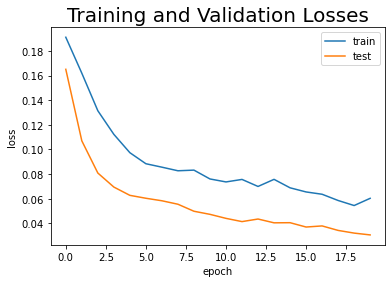

In [5]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [6]:
# Using the newly trained model compute the embeddings 
# for a number images
sample_size = 5000

X_train_trm = base_model.predict(X_train[:sample_size].reshape(-1,28,28,1))
X_test_trm = base_model.predict(X_test[:sample_size].reshape(-1,28,28,1))

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)


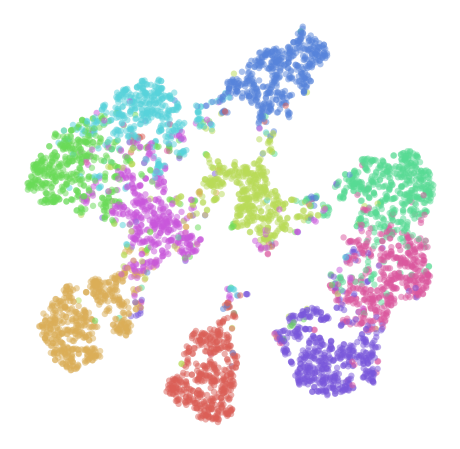

In [7]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    

scatter(train_tsne_embeds, y_train[:sample_size])


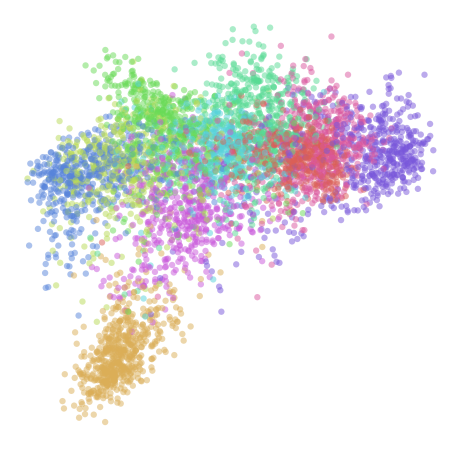

In [8]:
scatter(X_train_trm, y_train[:sample_size])

In [9]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((10,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(y_train, 10)[:sample_size]
Y_test_onehot = np_utils.to_categorical(y_test, 10)[:sample_size]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=10)

Epoch 1/10
157/157 [==============================] - 0s 2ms/step - loss: 2.3159 - accuracy: 0.0262 - val_loss: 2.2465 - val_accuracy: 0.0792
Epoch 2/10
157/157 [==============================] - 0s 1ms/step - loss: 2.1545 - accuracy: 0.2254 - val_loss: 2.1029 - val_accuracy: 0.3336
Epoch 3/10
157/157 [==============================] - 0s 2ms/step - loss: 2.0108 - accuracy: 0.5160 - val_loss: 1.9740 - val_accuracy: 0.5862
Epoch 4/10
157/157 [==============================] - 0s 2ms/step - loss: 1.8820 - accuracy: 0.6584 - val_loss: 1.8581 - val_accuracy: 0.6666
Epoch 5/10
157/157 [==============================] - 0s 1ms/step - loss: 1.7662 - accuracy: 0.7080 - val_loss: 1.7534 - val_accuracy: 0.6920
Epoch 6/10
157/157 [==============================] - 0s 1ms/step - loss: 1.6620 - accuracy: 0.7320 - val_loss: 1.6586 - val_accuracy: 0.7018
Epoch 7/10
157/157 [==============================] - 0s 1ms/step - loss: 1.5681 - accuracy: 0.7382 - val_loss: 1.5733 - val_accuracy: 0.7090
Epoch 

In [ ]:
# from google.colab import files
# import io
# uploaded = files.upload()


/home/alexkay/anaconda3/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [ ]:
# def gini(x):
#     # calculates the gini coeffiecent of 
#     # an array. 
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     rmad = mad/np.mean(x)
#     g = 0.5 * rmad
#     return g

# def DigitOrNumber(x):
#   # Creates an embedding for an image and then calculates the 
#   # equality of the softmax prediction distribution if it is below a certain threshold
#   # then the image will be classified as a digit
#   temp = base_model.predict(x)
#   temp = Classifier_model.predict(temp)
#   if gini(temp) < 0.87:
#     print(np.argmax(temp))
#   else:
#     print('Input is not a Digit')
    
# # a few examples
# x= np.load(io.BytesIO(uploaded['emnist_train_images_3 (1).npy'])) 
# DigitOrNumber(x[0:1])
# DigitOrNumber(x[1:2])
# DigitOrNumber(x[2:3])
# DigitOrNumber(X_test[20:21])
# DigitOrNumber(X_test[500:501])
# DigitOrNumber(X_test[1007:1008])